# Unsupervised K-means Clustering of Random Pictures

### Exploring various methods to initialize the cluster centroids & increase the accuracy of the algorithm

In the end we will check the clusters and see if it worked!

In [2]:
% matplotlib inline
import os, os.path
import random
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import kmeans as kmeans
import pca as pca_dr
import neuralnet

## Data set consists of Dogs, Cats, Flowers and Cars.

The images are stored under the images folder. 
The subfolders are:

1. Cars

2. Dogs

3. Cats

4. Flowers

Each subfolder contains 150 to 300 images

In [76]:
image_dir = "./images"
def data_info():
    
    # dictionary where we will store the count of each group of images
    info = []
    image_directory = [name for name in os.listdir(image_dir)]
    
    # Going through each subfolder under images and finding the count of each label
    for sub_directory in image_directory:
        directory_path = glob.glob("{}/{}".format(image_dir, sub_directory))[0]
        file_names = [file for file in os.listdir(directory_path)]
        file_count = len(file_names)
        sub_directory_name = os.path.basename(directory_path)
        info.append({ "Category": sub_directory_name,
                        "Count": file_count, 
                       "Directory": os.path.basename(directory_path),
                        "File names": file_names})

    
    df = pd.DataFrame(info)
    
    return df

In [77]:
dataset = data_info().set_index("Category")
dataset[["Directory", "Count"]]

,Directory,Count
Category,,
Cars,Cars,155
Cats,Cats,203
Circle,Circle,260
Dogs,Dogs,199
Flowers,Flowers,160
Square,Square,260
Star,Star,260
Triangle,Triangle,260


### Reading the images

We have images of variable sizes. 

Firstly, we convert all the images to 250  x 250 pixels with each pixel representing 3 value (RGB).
Later we convert this into a feature space of 250 x 250 x 3 = 187500

In [78]:
#Function to read images of selected categories and return the images with its respective labels(category). 
def read_images(categories):
    
    images = []
    labels = []
    
    for category in categories:
        # get the directory for this category
        folder_name = dataset.loc[category]["Directory"]
        
        for file in dataset.loc[category]["File names"]:                 
            file_path = os.path.join(image_dir, folder_name, file)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (250,250))
            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            labels.append(category)

    return images, labels

In [79]:
categories = ["Cars", "Dogs", "Flowers"]
images, labels = read_images(categories)

### Displaying the images

Lets view 3 random images from each selected label

In [80]:
def show_images(images, labels, number_of_images_to_show=5):

    for temp in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == temp]
        random_idx = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("label: "+temp)
        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_idx[image]])
        plt.show()

label: Flowers


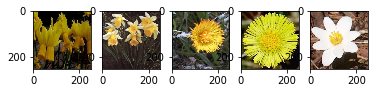

label: Dogs


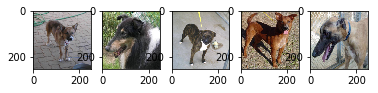

label: Cars


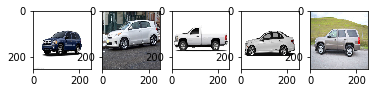

In [81]:
show_images(images, labels)

### Normalization.

We will be converting the images and labels to NumPy arrays and normalizing it would make the conparisons easier since all the values will be scaled down to 0 to 1.

In [82]:
#Function to scale the images to values between 0 and 1 to facilitate comparisons
def normalize_images(images, labels):

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)
    # scaling it to values between 0 and 1
    images /= 255
    
    return images, labels

As we can see below the values now range from 0 to 1. 

In [83]:
images, labels = normalize_images(images, labels)
print(images.shape)
print(images[1])

(514, 250, 250, 3)
[[[0.49019608 0.4745098  0.4627451 ]
  [0.47843137 0.4627451  0.45882353]
  [0.4862745  0.47058824 0.4745098 ]
  ...
  [0.92941177 0.92941177 0.92156863]
  [0.9137255  0.9137255  0.9137255 ]
  [0.8392157  0.8392157  0.84313726]]

 [[0.4745098  0.45882353 0.44313726]
  [0.47843137 0.4627451  0.45882353]
  [0.47058824 0.45490196 0.45882353]
  ...
  [0.9098039  0.9098039  0.9019608 ]
  [0.9137255  0.9137255  0.9137255 ]
  [0.78039217 0.78039217 0.7882353 ]]

 [[0.45490196 0.4392157  0.42745098]
  [0.45882353 0.44313726 0.4392157 ]
  [0.49019608 0.4745098  0.47843137]
  ...
  [0.85490197 0.85490197 0.84705883]
  [0.88235295 0.88235295 0.88235295]
  [0.73333335 0.73333335 0.7411765 ]]

 ...

 [[0.7372549  0.76862746 0.7764706 ]
  [0.7176471  0.7137255  0.73333335]
  [0.8784314  0.89411765 0.90588236]
  ...
  [0.7019608  0.70980394 0.7058824 ]
  [0.65882355 0.6666667  0.6627451 ]
  [0.57254905 0.5803922  0.5764706 ]]

 [[0.93333334 0.96862745 0.972549  ]
  [0.70980394 0.70

### Mixing the dataset for the first run.

We will split the data into three different sets: 
1. training
2. validation
3. test.

Also, since the current dataset is ordered in folders we need to mix it up using the train_test_split function from sklearn

In [84]:
#Function to shuffle the images as it is read in an orderly fashion
def mix_images(images, labels):

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0, random_state=728)
    
    return X_train, y_train

In [85]:
images, labels = mix_images(images, labels)

### Principal Component Analysis

As we saw before the dimension of this dataset it pretty huge. And running K-means on this huge dataset is computationally expensive.

Hence we need to use dimensionality reduction algorithms like PCA. 

#### Understanding PCA
Let us take a small sample shown below to understand PCA

array([[3.03727735, 1.6121232 ],
       [1.6121232 , 2.19272771]])

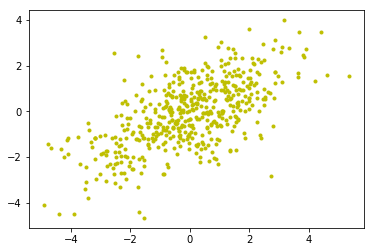

In [3]:
def sqrtm(M):
    (U, S, VT) = np.linalg.svd(M)
    D = np.diag(np.sqrt(S))
    return np.dot(np.dot(U, D), VT)

np.random.seed(422)

# Specify the sample covariance of the multivariate normal data
Si = sqrtm(np.array([[1,2],[3,2]]))
x = np.dot(np.random.randn(500,2), Si)

plt.plot(x[:,0], x[:,1], 'y.')
np.dot(x.T,x) / np.real(x.shape[0])

Let us run PCA on this example and visualize what happens

In [87]:
(P,Z,evals) = pca_dr.pca(x, 2)
print('Z:', Z)
print('evals:', evals)

Z: [[ 0.79220487 -0.61025523]
 [ 0.61025523  0.79220487]]
evals: [4.28200433 0.94921642]


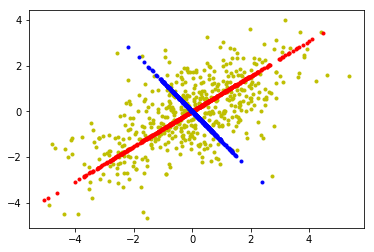

In [88]:
x0 = np.dot(np.dot(x, Z[:,0]).reshape(500,1), Z[:,0].reshape(1,2))
x1 = np.dot(np.dot(x, Z[:,1]).reshape(500,1), Z[:,1].reshape(1,2))
plt.plot(x[:,0], x[:,1], 'y.', x0[:,0], x0[:,1], 'r.', x1[:,0], x1[:,1], 'b.')

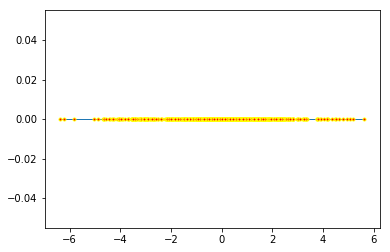

In [89]:
M = P[:,0].shape
y = np.zeros(M)
plt.plot(P[:,0], y, marker='o', markersize=3, markerfacecolor='red', markeredgecolor='yellow', linewidth=1)
plt.show()

In [90]:
flattened_images = images.flatten().reshape(images.shape[0], images.shape[1]*images.shape[2]*images.shape[3])
print(flattened_images.shape)
pca = PCA(n_components=None, random_state=728)
pca_images = pca.fit(flattened_images)

(514, 187500)


In [91]:
# We need to plot the cummulative variance of the components to see how many components are needed to preserve 95% variance 
def variance_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_), color="red")
    plt.xlabel('number of components')
    plt.ylabel('cumulative variance')
    plt.show()

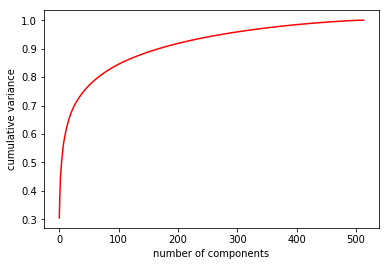

In [92]:
variance_plot(pca_images)

Looking at the gaphs above, we can see that PCA can explain almost all the variance in just 514 dimensions

In [93]:
# Reducing the feature space
reduced_images = pca_images.transform(flattened_images)
print("Dimension of the reduces dataset:", reduced_images.shape)

Dimension of the reduces dataset: (514, 514)


### K-means Clustering

The following function runs 5 iterations of 3 different initialization methods like (km++, farthest first hueristic and random)

In [94]:
# This functions performs kmeans algorithm using 3 different cluster initialization methods
def k_means_multi_heuristic(data, number_of_clusters=len(categories)):
    method = ["km++", "ffh", "random"]
    min_obj = np.finfo('d').max
    xmax = 0
    for m in method:
        sum_itr = 0
        for i in range(5):
            mu0 = kmeans.initialize_clusters(data, number_of_clusters, m)
            (mu,z,obj) = kmeans.kmeans(data, mu0, doPlot=False, verbose=False)
            plt.plot(obj)
            sum_itr = sum_itr + obj.shape[0]
            xmax = max(xmax, obj.shape[0])
            if (obj[-1] < min_obj):
                min_obj = obj[-1]
                min_mu = mu
                min_z = z
                min_heuristic = m
        avg_itr = sum_itr/5
        plt.ylim(200,15000)
        plt.xlim(0,xmax)
        plt.xlabel('Iterations')
        plt.ylabel('Objectives')
        plt.title(m)
        plt.show()
        print("avg number of iterations:", avg_itr)
    print("best heuristic:", min_heuristic)
    print("best objective:", min_obj)
    return min_z

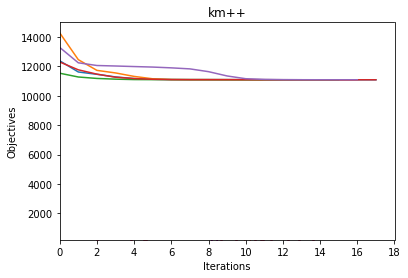

avg number of iterations: 17.2


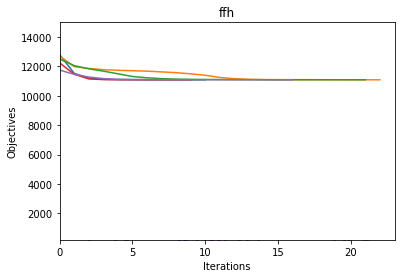

avg number of iterations: 16.6


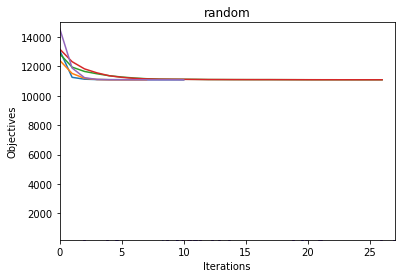

avg number of iterations: 16.8
best heuristic: ffh
best objective: 11091.210518085085


In [95]:
predicted_labels = k_means_multi_heuristic(reduced_images, len(categories))

### Analyzing the results
The clustering algorithm has no clue what these images are. It is grouping the images together based on similarity in the pictures like, the shape of objects, shade of the background etc

The stats below show how each image is classified. since we already know the labels, we can compare the actual values with the predicted values.

In [96]:
def cluster_analysis(predicted, actual):
    
    count = {}
    
    # Get all the unique predicted and actual categories
    unique_predicted = list(set(predicted))
    unique_actual = list(set(actual))
    # Create counter for each predicted/actual combination and set it to 0
    for p in unique_predicted:
        count[p] = {}
        for a in unique_actual:
            count[p][a] = 0
    for c in range(len(predicted)):
        count[predicted[c]][actual[c]] +=1
    stat_df = pd.DataFrame(count)    
    
    return stat_df

In [97]:
k_means_stats = cluster_analysis(predicted_labels, labels)

In [98]:
print("KMeans with PCA: ")
print(k_means_stats)

KMeans with PCA: 
           0   1    2
Cars      81  59   15
Dogs     154  23   22
Flowers   30   1  129


### Accuracy

Best way to estimate a Machine learning algorithm is with F1 score. 

In [99]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "F1 Score: {0:0.6f}".format(f1,acc)

#k_means_output contain the predicted_labels, images and actual_labels of these images
def scoring(k_means_categories_mapping, k_means_output):
    #Since the clusters are labelled 0, 1, 2,..., we need to set the cluster labels manually
    k_means_predicted_labels = [k_means_categories_mapping[x] for x in k_means_output[0]]

    print("KMeans with PCA:\n", print_scores(k_means_output[-1], k_means_predicted_labels))

In [100]:
# Map clusters with respective category labels manually to measure the accuracy
k_means_categories_mapping = ["Dogs", "Cars", "Flowers"]
k_means_predicted_labels = [k_means_categories_mapping[x] for x in predicted_labels]
print_scores(k_means_predicted_labels, labels)

'F1 Score: 0.650334'

#### Function to display the predicted cluster images.

In [101]:
#Fuction to see how the images are grouped
def display_predicted_images(categories, predicted_values, images):
    k_means_predicted_labels = [categories[x] for x in predicted_values]

    for category in categories:

        figure, axis = plt.subplots(1, 5)

        indices = [(i == category) for i in k_means_predicted_labels]
        print("predicted:", category)
        
        for image in range(5):
            axis[image].imshow(images[indices][image])
        plt.show()

### Putting it all together

Now lets combine all the functions above into a single function to run it on different sets of images and analyze the output

In [102]:
def k_means_image_sorter(categories):
    
    # Reading images
    images, labels = read_images(categories)
    print("total images:", len(images))
    show_images(images, labels)
    
    # Normalization
    images, labels = normalize_images(images, labels)
    
    # Shuffling the data
    images, labels = mix_images(images, labels)
    
    # Flatting the image
    flattened_images = images.flatten().reshape(images.shape[0], images.shape[1]*images.shape[2]*images.shape[3])
    
    # Reducing the dimensions using PCA from 250x250x3 = 187500 to 514
    pca = PCA(n_components=None, random_state=728)
    reduced_images = pca.fit(flattened_images).transform(flattened_images)
    
    # Clustering using k-means multi-heuristic algorithm
    predicted_labels = k_means_multi_heuristic(reduced_images, len(categories))

    # Analysis/stats of the output
    k_means_stats = cluster_analysis(predicted_labels, labels)
    print("\nKMeans with PCA: ")
    print(k_means_stats)

    return  predicted_labels, images, labels

total images: 402
label: Dogs


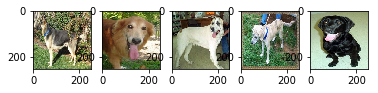

label: Cats


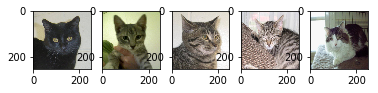

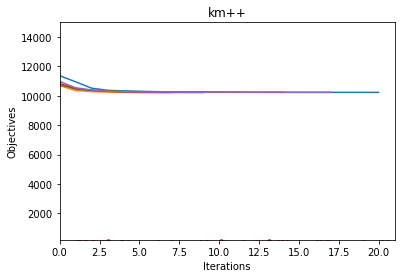

avg number of iterations: 14.4


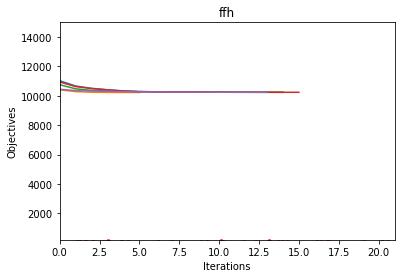

avg number of iterations: 13.2


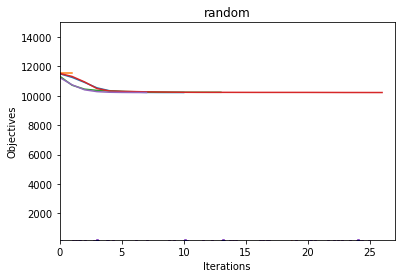

avg number of iterations: 12.4
best heuristic: random
best objective: 10224.711875213226

KMeans with PCA: 
       0    1
Cats  94  109
Dogs  69  130


In [103]:
categories = ["Cats", "Dogs"]
k_means_output = k_means_image_sorter(categories)

In [104]:
# Map clusters with respective category labels manually to measure the accuracy
k_means_categories_mapping = ["Cats", "Dogs"]

scoring(k_means_categories_mapping, k_means_output)

KMeans with PCA:
 F1 Score: 0.553634


predicted: Cats


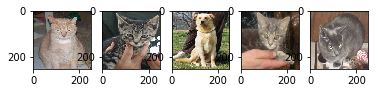

predicted: Dogs


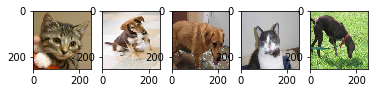

In [105]:
display_predicted_images(k_means_categories_mapping, k_means_output[0], k_means_output[1])

Lets try another set of images

total images: 363
label: Cats


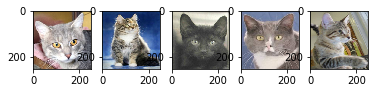

label: Flowers


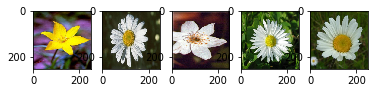

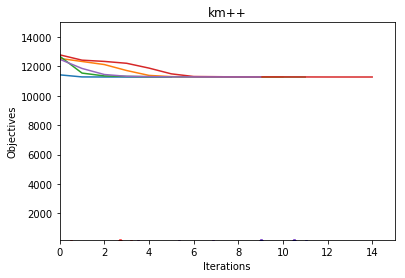

avg number of iterations: 10.8


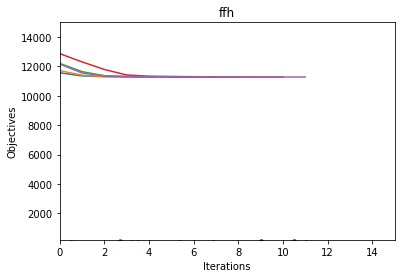

avg number of iterations: 9.6


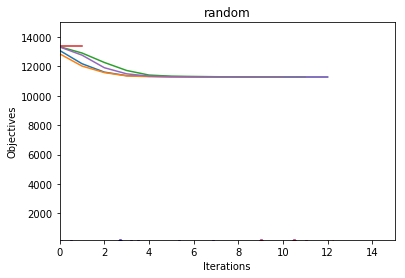

avg number of iterations: 10.2
best heuristic: km++
best objective: 11279.491894546343

KMeans with PCA: 
           0    1
Cats     136   67
Flowers   24  136


In [113]:
categories = ["Cats", "Flowers"]
k_means_output = k_means_image_sorter(categories)

We can see that this performed better than the other set of images

In [114]:
# Map clusters with respective category labels manually to measure the accuracy
k_means_categories_mapping = ["Cats", "Flowers"]

scoring(k_means_categories_mapping, k_means_output)

KMeans with PCA:
 F1 Score: 0.749311


predicted: Cats


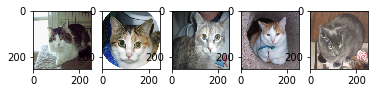

predicted: Flowers


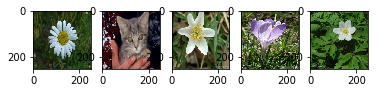

In [115]:
display_predicted_images(k_means_categories_mapping, k_means_output[0], k_means_output[1])

Another one!

total images: 315
label: Cars


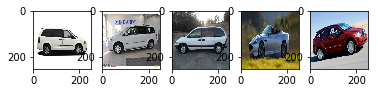

label: Flowers


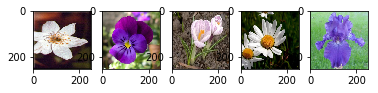

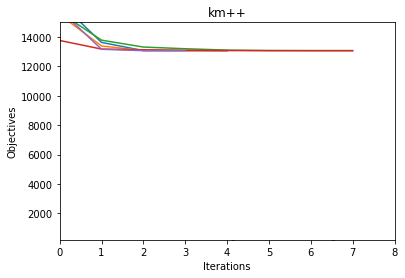

avg number of iterations: 6.0


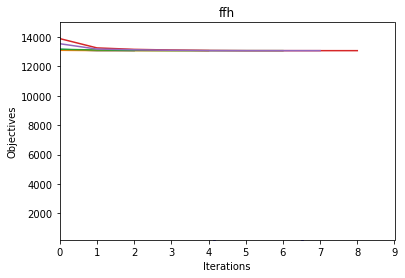

avg number of iterations: 6.4


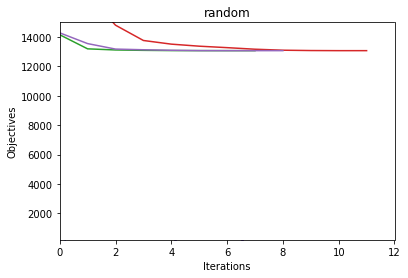

avg number of iterations: 6.6
best heuristic: km++
best objective: 13074.071000209547

KMeans with PCA: 
           0   1
Cars      75  80
Flowers  156   4


In [116]:
categories = ["Flowers", "Cars"]
k_means_output = k_means_image_sorter(categories)

In [117]:
# Map clusters with respective category labels manually to measure the accuracy
k_means_categories_mapping = ["Flowers", "Cars"]
scoring(k_means_categories_mapping, k_means_output)

KMeans with PCA:
 F1 Score: 0.733705


predicted: Flowers


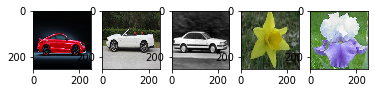

predicted: Cars


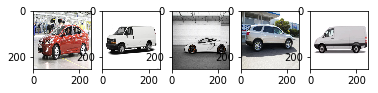

In [118]:
display_predicted_images(k_means_categories_mapping, k_means_output[0], k_means_output[1])

Let us see how the algorithm works on a dataset with non overlapping feature space

total images: 520
label: Square


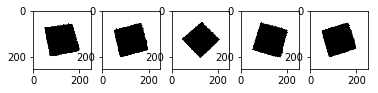

label: Triangle


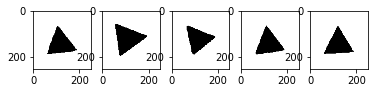

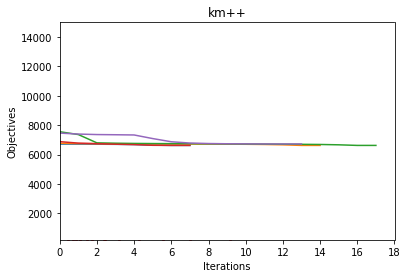

avg number of iterations: 12.6


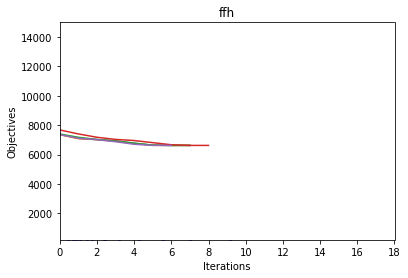

avg number of iterations: 8.0


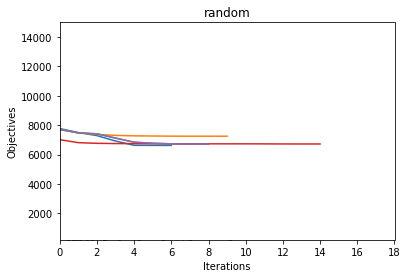

avg number of iterations: 10.0
best heuristic: km++
best objective: 6624.739158717532

KMeans with PCA: 
            0    1
Square    260    0
Triangle    0  260


In [119]:
labels = ["Square", "Triangle"]
k_means_output = k_means_image_sorter(labels)

In [120]:
# Map clusters with respective category labels manually to measure the accuracy
k_means_categories_mapping = ["Square", "Triangle"]
scoring(k_means_categories_mapping, k_means_output)

KMeans with PCA:
 F1 Score: 1.000000


predicted: Square


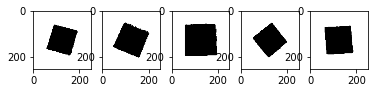

predicted: Triangle


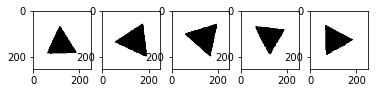

In [121]:
display_predicted_images(k_means_categories_mapping, k_means_output[0], k_means_output[1])

### Lets try supervised learning

Neural Nets with 2 hidden layers

total images: 402
label: Dogs


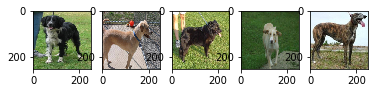

label: Cats


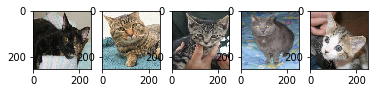

In [122]:
categories = ["Cats", "Dogs"]
# Reading images
images, labels = read_images(categories)
print("total images:", len(images))
show_images(images, labels)

# Normalization
images, labels = normalize_images(images, labels)

# Splitting the data
X_train, y_train = mix_images(images, labels)

# Flatting the image
flattened_images = X_train.flatten().reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])

# Reducing the dimensions using PCA
pca = PCA(n_components=None, random_state=728)
X_train_pca = pca.fit(flattened_images).transform(flattened_images)

In [123]:
X_img = X_train.flatten().reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
print(X_img.shape)
m = list(map(lambda x:1 if x == 'Dogs' else 0, y_train))
y_img = np.asarray(m)
print(X_train_pca.shape)

(402, 187500)
(402, 402)


Iteration: 0, Loss: 1.139097
Iteration: 1000, Loss: 0.419812
Iteration: 2000, Loss: 0.416617


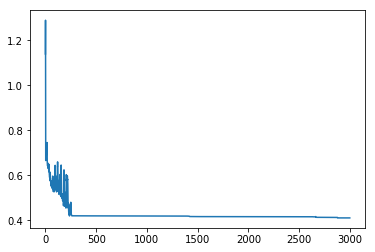

In [124]:
nn = neuralnet.ThreeLayerNet()
iterations,losses = nn.train(X_train_pca,y_img,input_dim=X_train_pca.shape[1],hdim=2,num_passes=3000,print_loss=True)
plt.plot(iterations,losses)

In [125]:
pred = nn.predict(X_train_pca)

In [126]:
pred_list = list(map(lambda x:'Dogs' if x == 1 else 'Cats', pred))
y_pred = np.asarray(pred_list)
nn_stats = cluster_analysis(pred, y_train)
print("Neural Nets clustering stats: ")
print(nn_stats)

Neural Nets clustering stats: 
        0    1
Cats  171   32
Dogs   29  170


predicted: Cats


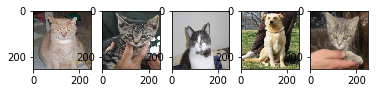

predicted: Dogs


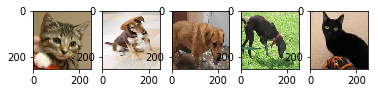

In [127]:
categories_mapping = ["Cats", "Dogs"]
display_predicted_images(categories_mapping, pred, X_train)

In [128]:
print_scores(y_train, y_pred)

'F1 Score: 0.848258'

Lets try another set of inmages

total images: 359
label: Dogs


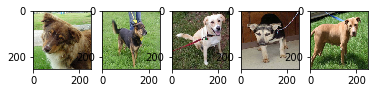

label: Flowers


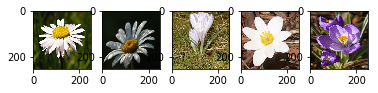

In [129]:
categories = ["Flowers", "Dogs"]
# Reading images
images, labels = read_images(categories)
print("total images:", len(images))
show_images(images, labels)

# Normalization
images, labels = normalize_images(images, labels)

# Splitting the data
X_train, y_train = mix_images(images, labels)

# Flatting the image
flattened_images = X_train.flatten().reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])

# Reducing the dimensions using PCA
pca = PCA(n_components=None, random_state=728)
X_train_pca = pca.fit(flattened_images).transform(flattened_images)

In [130]:
X_img = X_train.flatten().reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
print(X_img.shape)
m = list(map(lambda x:1 if x == 'Flowers' else 0, y_train))
y_img = np.asarray(m)
print(X_train_pca.shape)

(359, 187500)
(359, 359)


Iteration: 0, Loss: 0.551493
Iteration: 1000, Loss: 0.264120
Iteration: 2000, Loss: 0.263728


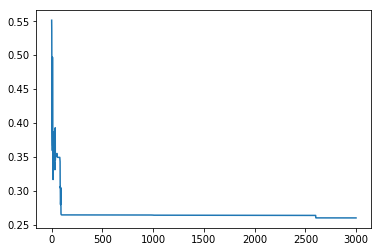

In [131]:
nn = neuralnet.ThreeLayerNet()
iterations,losses = nn.train(X_train_pca,y_img,input_dim=X_train_pca.shape[1],hdim=2,num_passes=3000,print_loss=True)
plt.plot(iterations,losses)

In [132]:
pred = nn.predict(X_train_pca)

In [133]:
pred_list = list(map(lambda x:'Flowers' if x == 1 else 'Dogs', pred))
y_pred = np.asarray(pred_list)
nn_stats = cluster_analysis(pred, y_train)
print("Neural Nets clustering stats: ")
print(nn_stats)

Neural Nets clustering stats: 
           0    1
Dogs     180   19
Flowers    9  151


predicted: Dogs


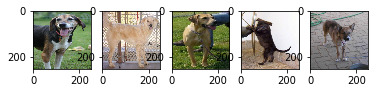

predicted: Flowers


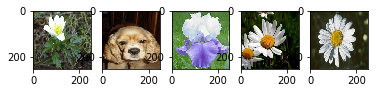

In [134]:
categories_mapping = ["Dogs", "Flowers"]
display_predicted_images(categories_mapping, pred, X_train)

In [135]:
print_scores(y_train, y_pred)

'F1 Score: 0.921493'